In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning',
 '/opt/conda/lib/python38.zip',
 '/opt/conda/lib/python3.8',
 '/opt/conda/lib/python3.8/lib-dynload',
 '',
 '/home/blessyantony/.local/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages',
 '/opt/conda/lib/python3.8/site-packages/IPython/extensions',
 '/home/blessyantony/.ipython',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../../..',
 '/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/few_shot_learning/../..']

In [4]:
!pip install seaborn==0.13.0

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import textwrap
from sklearn.metrics import roc_curve, accuracy_score, f1_score, auc, precision_recall_curve
from statistics import mean

from src.utils import utils, evaluation_utils, visualization_utils

In [20]:
virprobert_output_auprc_file_paths =  {
    "sl256st64_w5s5": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20240924/host_multi/few_shot_learning/fsl_tr_w3s3q10_te_walls3q-1_tsk10e1b32_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv"),
    #"sl256st64_w5s2": os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_non_idv/20240906/host_multi/few_shot_learning/fsl_tr_w5s2q10_te_w5s2q-1_e100b32_split70-10-20_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_classwise_auprc.csv")
}
dataset_file_path = os.path.join(os.getcwd(), "..","..", "..", "input/data/uniref90/20240131/uniref90_viridae_embl_hosts_pruned_metadata_species_vertebrates_w_seq_idv.csv")

In [21]:
def read_output_df(output_file_paths):
    dfs = []
    for model, output_file_path in output_file_paths.items():
        df = pd.read_csv(output_file_path, index_col=0)
        df["model"] = model
        dfs.append(df)
    return pd.concat(dfs)


def compute_class_distribution(df, label_col, n, format=False):
    labels_counts = df[label_col].value_counts()
    labels_counts = labels_counts / n * 100
    labels_counts = labels_counts.to_dict()
    if format:
        labels_counts = {k: f"{k}\n({v:.3f}%)" for k, v, in labels_counts.items()}
    return labels_counts

In [22]:
df = read_output_df(virprobert_output_auprc_file_paths)
dataset_df = pd.read_csv(dataset_file_path)

In [23]:
df.shape

(1630, 10)

In [24]:
class_vals = list(df["y_true"].unique())

In [25]:
df["y_pred"] = df[class_vals].idxmax(axis=1)

In [26]:
df

,Cercocebus atys,Cercocebus torquatus,Cercopithecus aethiops,Cercopithecus erythrotis,Cercopithecus mitis,Cercopithecus solatus,Miopithecus ogouensis,y_true,itr,model,y_pred
0,9.578670e-01,3.989430e-04,2.715512e-07,5.048289e-04,1.853625e-02,1.817819e-04,2.251098e-02,Cercocebus atys,0,sl256st64_w5s5,Cercocebus atys
1,9.696993e-01,6.222146e-09,7.274053e-12,1.149025e-08,3.029384e-02,1.204105e-06,5.549426e-06,Cercocebus atys,0,sl256st64_w5s5,Cercocebus atys
2,9.233713e-01,2.009397e-09,1.434797e-09,2.001081e-10,6.319498e-02,1.343381e-02,1.459839e-10,Cercocebus atys,0,sl256st64_w5s5,Cercocebus atys
3,6.123739e-10,7.849174e-03,1.731004e-05,9.921198e-01,2.238673e-08,2.303780e-07,1.339358e-05,Cercocebus atys,0,sl256st64_w5s5,Cercopithecus erythrotis
4,9.999424e-01,1.707404e-12,1.763875e-13,3.412916e-12,5.755464e-05,3.240511e-08,1.451357e-11,Cercocebus atys,0,sl256st64_w5s5,Cercocebus atys
...,...,...,...,...,...,...,...,...,...,...,...
1625,1.560060e-01,1.322355e-08,3.524850e-07,3.395095e-07,5.251557e-04,1.936739e-01,6.497942e-01,Cercopithecus solatus,0,sl256st64_w5s5,Miopithecus ogouensis
1626,2.936828e-04,3.127577e-05,6.602540e-06,5.562664e-10,9.459747e-01,5.021815e-03,4.867201e-02,Cercopithecus solatus,0,sl256st64_w5s5,Cercopithecus mitis
1627,1.080837e-04,8.849383e-11,1.020480e-09,9.389440e-12,2.376559e-05,6.504451e-03,9.933637e-01,Cercopithecus solatus,0,sl256st64_w5s5,Miopithecus ogouensis
1628,4.684000e-05,2.871084e-03,2.119559e-02,6.218458e-08,5.245472e-01,6.684568e-03,4.446547e-01,Cercopithecus solatus,0,sl256st64_w5s5,Cercopithecus mitis


In [27]:
df["y_pred"].unique()

array(['Cercocebus atys', 'Cercopithecus erythrotis',
       'Cercocebus torquatus', 'Cercopithecus mitis',
       'Miopithecus ogouensis', 'Cercopithecus aethiops',
       'Cercopithecus solatus'], dtype=object)

In [28]:
print(dataset_df.shape)
print(df["model"].unique())
print(df["class"].unique())


(220068, 11)
['sl256st64_w5s5']


KeyError: 'class'

In [12]:
metadata_formatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=True)
metadata_formatted

{'Homo sapiens': 'Homo sapiens\n(99.347%)',
 'Macaca mulatta': 'Macaca mulatta\n(0.386%)',
 'Felis catus': 'Felis catus\n(0.065%)',
 'Cercocebus atys': 'Cercocebus atys\n(0.055%)',
 'Puma concolor': 'Puma concolor\n(0.011%)',
 'Macaca nemestrina': 'Macaca nemestrina\n(0.010%)',
 'Mandrillus sphinx': 'Mandrillus sphinx\n(0.010%)',
 'Mandrillus leucophaeus': 'Mandrillus leucophaeus\n(0.009%)',
 'Cercopithecus nictitans': 'Cercopithecus nictitans\n(0.009%)',
 'Cercopithecus solatus': 'Cercopithecus solatus\n(0.008%)',
 'Cercocebus torquatus': 'Cercocebus torquatus\n(0.007%)',
 'Cercopithecus aethiops': 'Cercopithecus aethiops\n(0.006%)',
 'Cercopithecus cephus': 'Cercopithecus cephus\n(0.006%)',
 'Chlorocebus sabaeus': 'Chlorocebus sabaeus\n(0.006%)',
 'Colobus guereza': 'Colobus guereza\n(0.006%)',
 'Panthera leo': 'Panthera leo\n(0.005%)',
 'Cercopithecus neglectus': 'Cercopithecus neglectus\n(0.005%)',
 'Cercopithecus mona': 'Cercopithecus mona\n(0.005%)',
 'Chlorocebus tantalus': 'Chl

In [13]:
dataset_df["virus_host_name"].nunique()

40

In [14]:
metadata_unformatted = compute_class_distribution(dataset_df, "virus_host_name", n=220068, format=False)
metadata_unformatted

{'Homo sapiens': 99.34702001199629,
 'Macaca mulatta': 0.3857898467746333,
 'Felis catus': 0.0649799152989076,
 'Cercocebus atys': 0.05543741025501209,
 'Puma concolor': 0.010905720050166313,
 'Macaca nemestrina': 0.01045131504807605,
 'Mandrillus sphinx': 0.01045131504807605,
 'Mandrillus leucophaeus': 0.009088100041805259,
 'Cercopithecus nictitans': 0.008633695039714997,
 'Cercopithecus solatus': 0.007724885035534471,
 'Cercocebus torquatus': 0.0072704800334442085,
 'Cercopithecus aethiops': 0.0063616700292636824,
 'Cercopithecus cephus': 0.005907265027173419,
 'Chlorocebus sabaeus': 0.005907265027173419,
 'Colobus guereza': 0.005907265027173419,
 'Panthera leo': 0.005452860025083156,
 'Cercopithecus neglectus': 0.005452860025083156,
 'Cercopithecus mona': 0.0045440500209026295,
 'Chlorocebus tantalus': 0.0045440500209026295,
 'Felis silvestris catus': 0.004089645018812368,
 'Cercopithecus lhoesti': 0.0036352400167221043,
 'Chlorocebus pygerythrus': 0.0031808350146318412,
 'Cercopit

In [15]:
df["prevalence"] = df["class"].apply(lambda x: metadata_unformatted[x])
df

,class,auprc,itr,model,prevalence
0,Cercocebus atys,0.800826,0,sl256st64_w5s5,0.055437
1,Cercocebus torquatus,0.197514,0,sl256st64_w5s5,0.007270
2,Cercopithecus aethiops,0.122858,0,sl256st64_w5s5,0.006362
3,Cercopithecus erythrotis,0.020847,0,sl256st64_w5s5,0.002272
4,Cercopithecus mitis,0.056918,0,sl256st64_w5s5,0.002726
...,...,...,...,...,...
65,Cercopithecus aethiops,0.074588,0,sl256st64_w5s5,0.006362
66,Cercopithecus erythrotis,0.514517,0,sl256st64_w5s5,0.002272
67,Cercopithecus mitis,0.011539,0,sl256st64_w5s5,0.002726
68,Cercopithecus solatus,0.080428,0,sl256st64_w5s5,0.007725


In [16]:
classes = list(metadata_unformatted.keys())
classes

['Homo sapiens',
 'Macaca mulatta',
 'Felis catus',
 'Cercocebus atys',
 'Puma concolor',
 'Macaca nemestrina',
 'Mandrillus sphinx',
 'Mandrillus leucophaeus',
 'Cercopithecus nictitans',
 'Cercopithecus solatus',
 'Cercocebus torquatus',
 'Cercopithecus aethiops',
 'Cercopithecus cephus',
 'Chlorocebus sabaeus',
 'Colobus guereza',
 'Panthera leo',
 'Cercopithecus neglectus',
 'Cercopithecus mona',
 'Chlorocebus tantalus',
 'Felis silvestris catus',
 'Cercopithecus lhoesti',
 'Chlorocebus pygerythrus',
 'Cercopithecus mitis',
 'Cercopithecus erythrotis',
 'Felis domesticus',
 'Macaca arctoides',
 'Macaca fascicularis',
 'Semnopithecus entellus',
 'Bos taurus',
 'Miopithecus ogouensis',
 'Cercopithecus ascanius',
 'Cercocebus torquatus atys',
 'Lynx rufus',
 'Cercopithecus aethiops pygerythrus',
 'Piliocolobus tephrosceles',
 'Piliocolobus badius',
 'Otocolobus manul',
 'Panthera pardus',
 'Papio ursinus',
 'Procolobus verus']

In [17]:
classes_order = {k:i for i, k in enumerate(classes)}
classes_order

{'Homo sapiens': 0,
 'Macaca mulatta': 1,
 'Felis catus': 2,
 'Cercocebus atys': 3,
 'Puma concolor': 4,
 'Macaca nemestrina': 5,
 'Mandrillus sphinx': 6,
 'Mandrillus leucophaeus': 7,
 'Cercopithecus nictitans': 8,
 'Cercopithecus solatus': 9,
 'Cercocebus torquatus': 10,
 'Cercopithecus aethiops': 11,
 'Cercopithecus cephus': 12,
 'Chlorocebus sabaeus': 13,
 'Colobus guereza': 14,
 'Panthera leo': 15,
 'Cercopithecus neglectus': 16,
 'Cercopithecus mona': 17,
 'Chlorocebus tantalus': 18,
 'Felis silvestris catus': 19,
 'Cercopithecus lhoesti': 20,
 'Chlorocebus pygerythrus': 21,
 'Cercopithecus mitis': 22,
 'Cercopithecus erythrotis': 23,
 'Felis domesticus': 24,
 'Macaca arctoides': 25,
 'Macaca fascicularis': 26,
 'Semnopithecus entellus': 27,
 'Bos taurus': 28,
 'Miopithecus ogouensis': 29,
 'Cercopithecus ascanius': 30,
 'Cercocebus torquatus atys': 31,
 'Lynx rufus': 32,
 'Cercopithecus aethiops pygerythrus': 33,
 'Piliocolobus tephrosceles': 34,
 'Piliocolobus badius': 35,
 'Ot

In [18]:
import math

def get_uniformly_divided_position_bins(positions, n_bins):
    bin_width = math.floor(len(positions)/n_bins)
    bins = []
    start = 0
    for i in range(n_bins):
        end = start + bin_width
        bins.append(positions[start:end])
        start = end
    return bins

<Figure size 432x288 with 0 Axes>

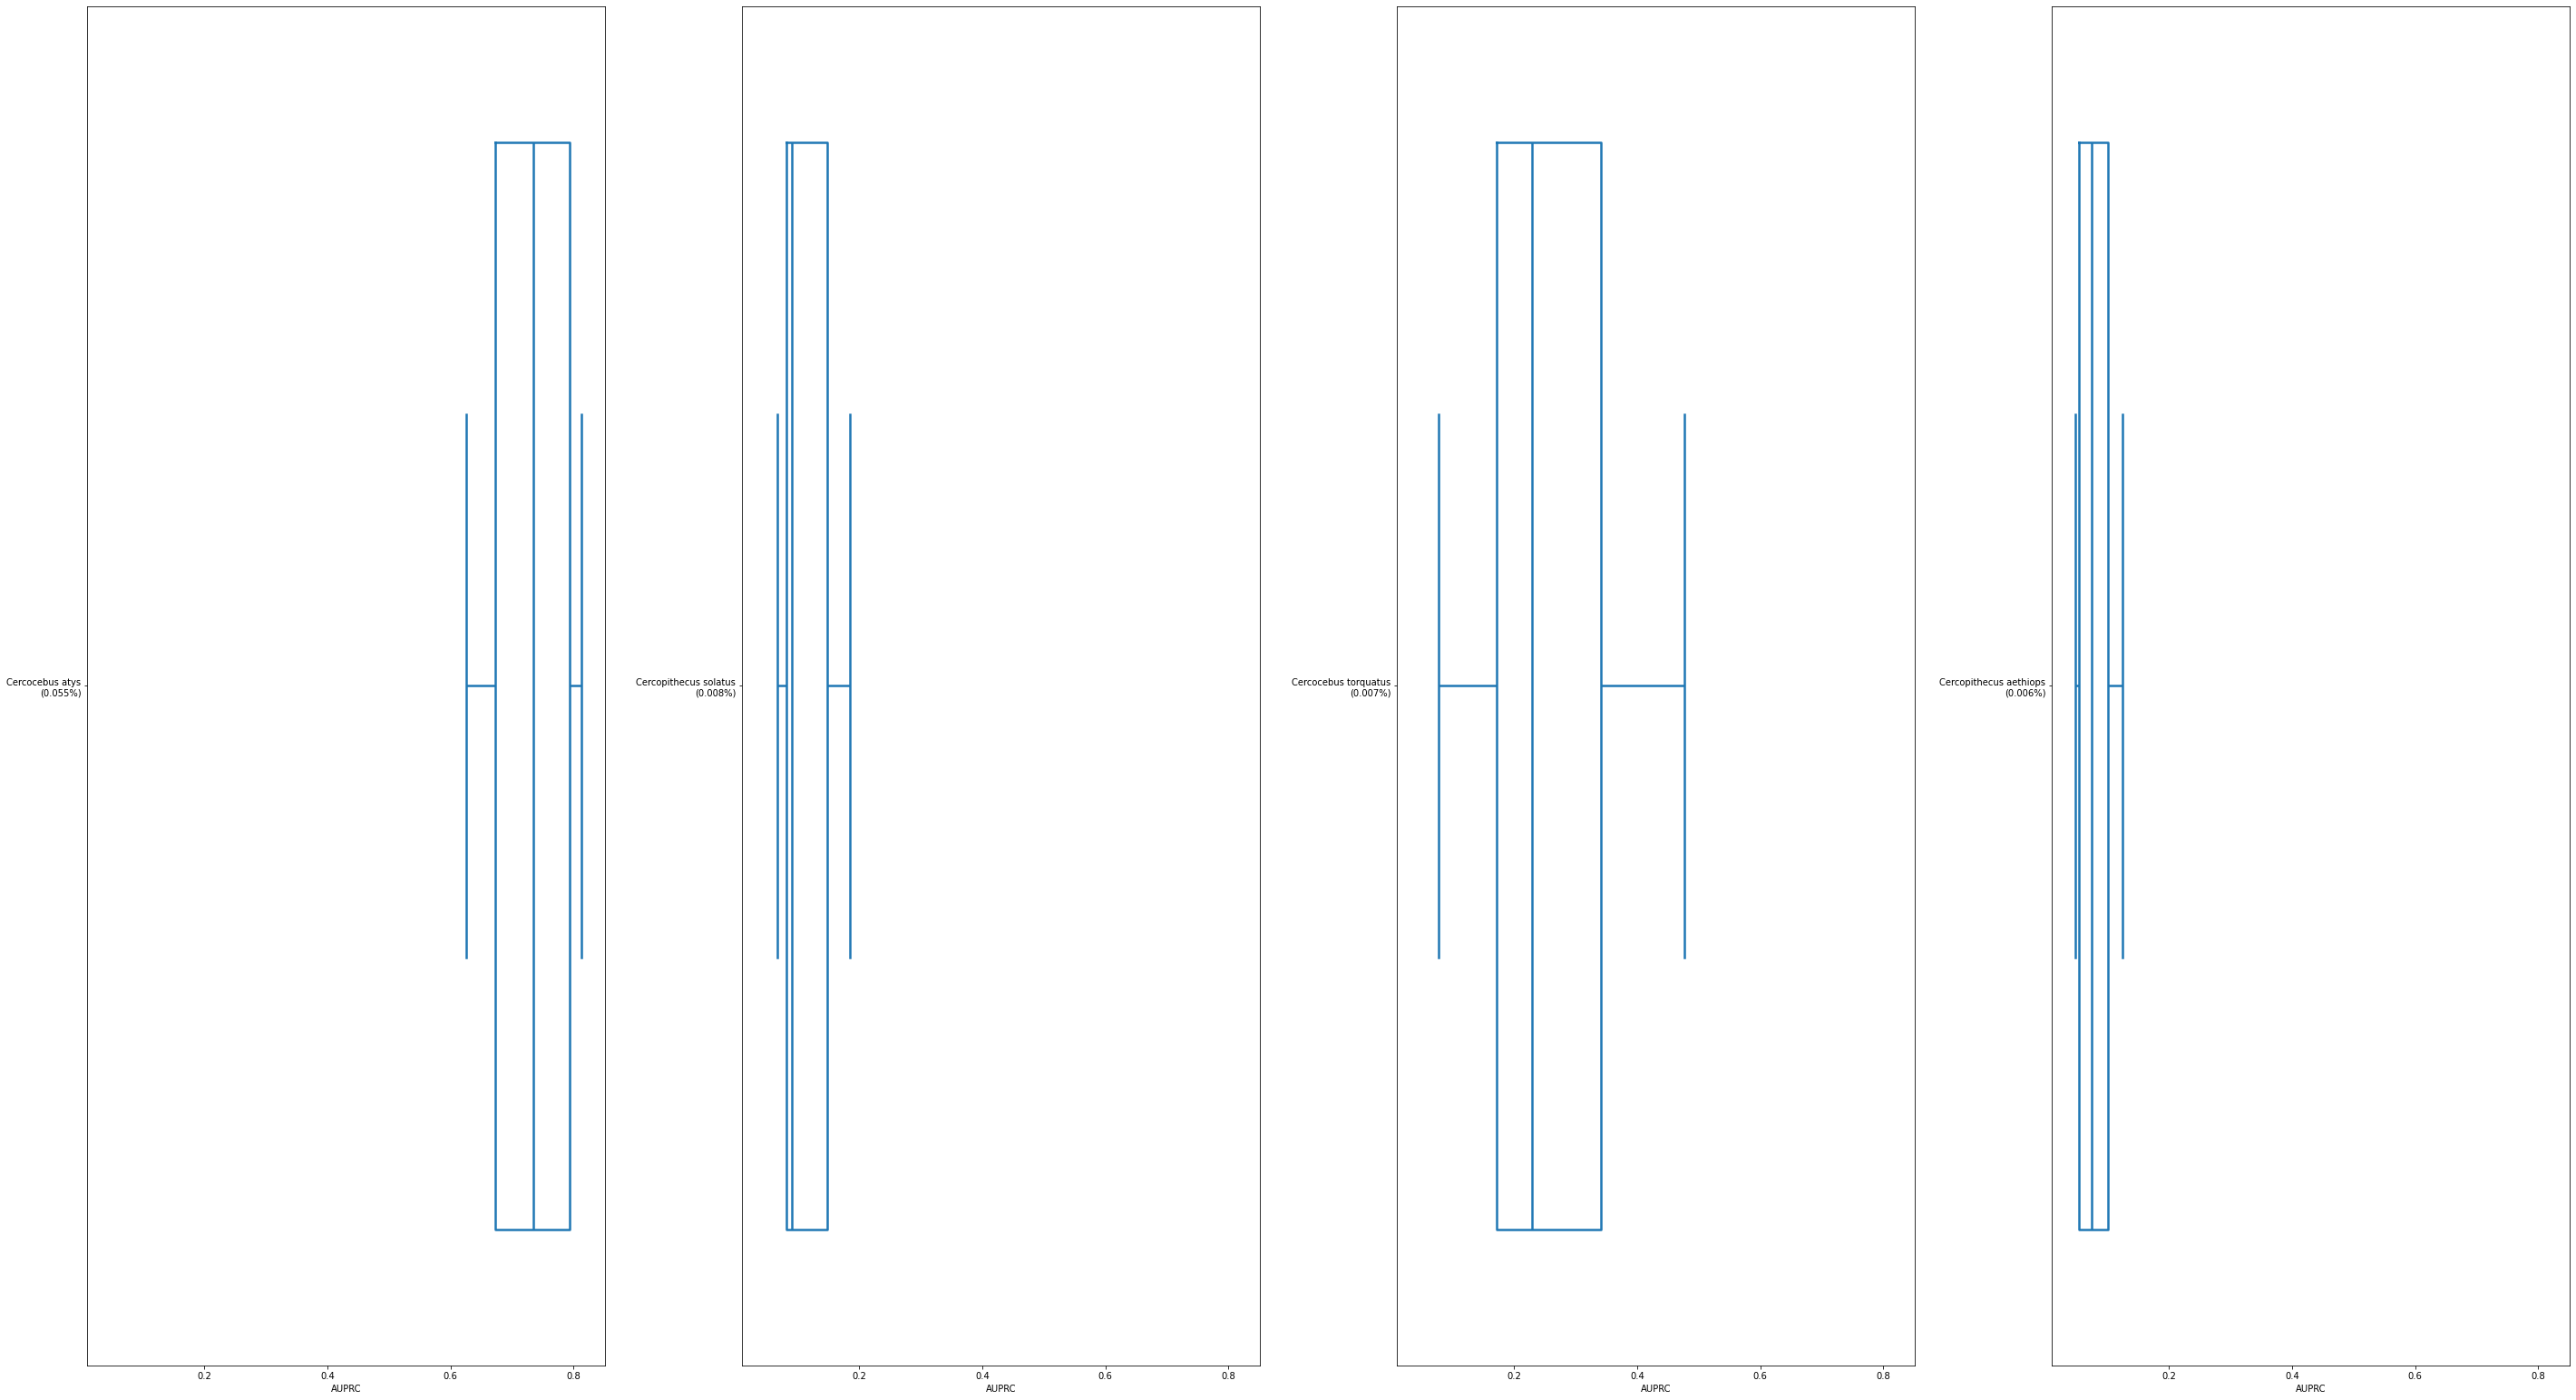

In [19]:
plt.rcParams['figure.autolayout'] = True
plt.clf()
fig, axs = plt.subplots(1, 4, figsize=(40, 22), sharex=True)
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams.update({'font.size': 25})

df.sort_values(by=["class"], key=lambda x: x.map(classes_order), inplace=True)
formatted_df = df.replace({"class": metadata_formatted})
classes = list(formatted_df["class"].unique())
bins = get_uniformly_divided_position_bins(list(classes), 4)
for i in range(4):
    #sns.violinplot(data=df[df["class"].isin(bins[i])],  x="auprc", y="class", hue="model", ax=axs[i], split=True, orient="h", linewidth=2.5, fill=False,  order=bins[i])
    sns.boxplot(data=formatted_df[formatted_df["class"].isin(bins[i])],  x="auprc", y="class", ax=axs[i], orient="h", linewidth=2.5, fill=False, fliersize=2.5, order=bins[i])
    
    #sns.stripplot(data=formatted_df[formatted_df["class"].isin(bins[i])], x="auprc", y="class", ax=axs[i], orient="h", color="black", order=bins[i])
    #plt.draw()

    axs[i].set_ylabel("")
    axs[i].set_xlabel("AUPRC")

plt.tight_layout(pad=.1)
plt.savefig(os.path.join(os.getcwd(), "..","..", "..", "output/visualization/temp_new/host_multi_fsl_idv_classwise_boxplot.pdf"))
plt.show()

In [30]:
df = pd.read_csv(os.path.join(os.getcwd(), "..","..", "..", "output/raw/uniref90_embl_vertebrates_idv_unseen_hosts/20240924/host_multi/few_shot_learning/fsl_tr_w3s3q10_te_walls3q-1_tsk10e1b32_split70-10-20-gpu2_hybrid-attention_sl256st64vs30_ae_bn_fnn_2l_d1024_lr1e-4_output.csv"), index_col=0)

In [31]:
df

,Cercocebus atys,Cercocebus torquatus,Cercopithecus aethiops,Cercopithecus erythrotis,Cercopithecus mitis,Cercopithecus solatus,Miopithecus ogouensis,y_true,itr
0,9.578670e-01,3.989430e-04,2.715512e-07,5.048289e-04,1.853625e-02,1.817819e-04,2.251098e-02,Cercocebus atys,0
1,9.696993e-01,6.222146e-09,7.274053e-12,1.149025e-08,3.029384e-02,1.204105e-06,5.549426e-06,Cercocebus atys,0
2,9.233713e-01,2.009397e-09,1.434797e-09,2.001081e-10,6.319498e-02,1.343381e-02,1.459839e-10,Cercocebus atys,0
3,6.123739e-10,7.849174e-03,1.731004e-05,9.921198e-01,2.238673e-08,2.303780e-07,1.339358e-05,Cercocebus atys,0
4,9.999424e-01,1.707404e-12,1.763875e-13,3.412916e-12,5.755464e-05,3.240511e-08,1.451357e-11,Cercocebus atys,0
...,...,...,...,...,...,...,...,...,...
1625,1.560060e-01,1.322355e-08,3.524850e-07,3.395095e-07,5.251557e-04,1.936739e-01,6.497942e-01,Cercopithecus solatus,0
1626,2.936828e-04,3.127577e-05,6.602540e-06,5.562664e-10,9.459747e-01,5.021815e-03,4.867201e-02,Cercopithecus solatus,0
1627,1.080837e-04,8.849383e-11,1.020480e-09,9.389440e-12,2.376559e-05,6.504451e-03,9.933637e-01,Cercopithecus solatus,0
1628,4.684000e-05,2.871084e-03,2.119559e-02,6.218458e-08,5.245472e-01,6.684568e-03,4.446547e-01,Cercopithecus solatus,0


In [49]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
def class_wise_auprc_analysis(df, classes, figure_output_filepath=None):
    auprc_results = []
    itrs = df[itr_col].unique()
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
        #auprcs_df["model"] = model
        auprcs_df["itr"] = itr
        auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (15, 10),
        "xtick.labelsize": 20,
        "ytick.labelsize": 20    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.lineplot(data=auprc_results_df, x="class", y="auprc", markers=True, dashes=False)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=22)
    ax.set_xlabel("", size=22, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    # visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df


# compute class-wise auprc in given df
def compute_class_auprc(df, y_pred_columns, y_true_col):
    pr_curves = []
    auprcs = []
    for y_pred_column in y_pred_columns:
        precision, recall, _ = precision_recall_curve(y_true=df[y_true_col].values, probas_pred=df[y_pred_column].values, pos_label=y_pred_column)
        pr_curves.append(pd.DataFrame({"precision": precision, "recall": recall, "class": y_pred_column}))
        auprcs.append({"class": y_pred_column, "auprc": auc(recall, precision)})
    return pd.concat(pr_curves, ignore_index=True), pd.DataFrame(auprcs)

In [50]:
classes = df.columns

In [51]:
classes

Index(['Cercocebus atys', 'Cercocebus torquatus', 'Cercopithecus aethiops',
       'Cercopithecus erythrotis', 'Cercopithecus mitis',
       'Cercopithecus solatus', 'Miopithecus ogouensis', 'y_true', 'itr'],
      dtype='object')

In [52]:
classes = classes[:-2]

ValueError: AxesSubplot(0.0990528,0.0811944;0.778804x0.900806) has no legend attached.

<Figure size 432x288 with 0 Axes>

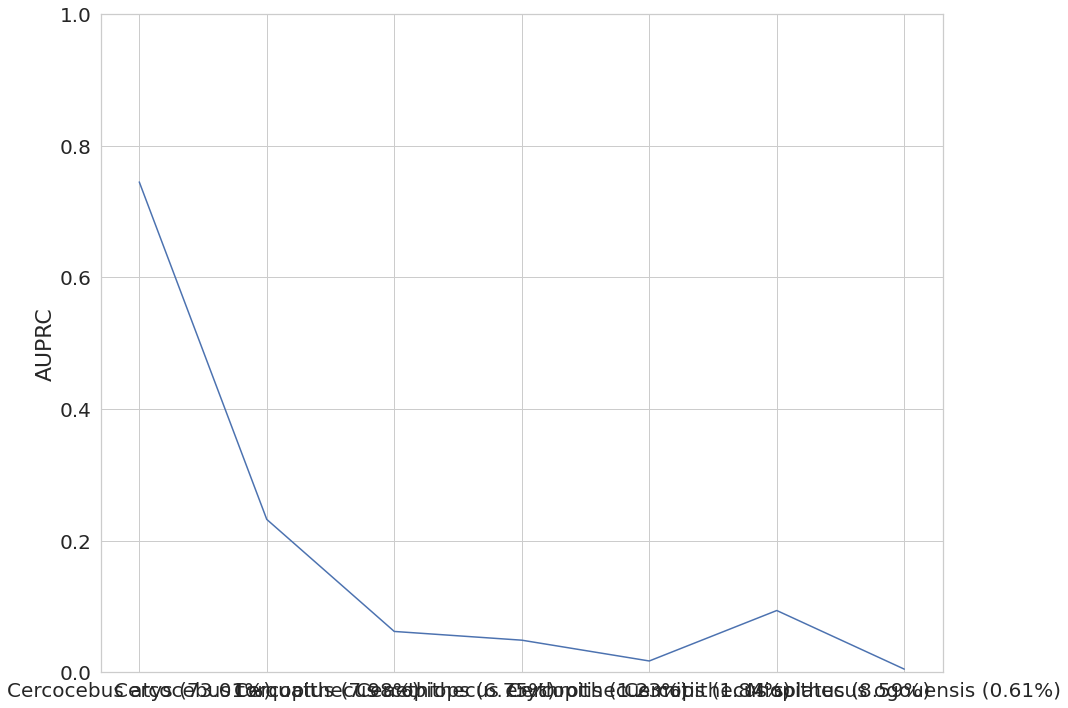

In [53]:
class_wise_auprc_analysis(df, classes, figure_output_filepath=None)